# Scanning MLPs: Achieving Position Invariance

## The Problem: Why Standard MLPs Fail at Position Invariance

For problems like:
- *"Does the word 'welcome' occur anywhere in this signal?"*
- *"Is there a flower anywhere in this image?"*

In these problems:
- **Location does not matter** — we don't care *where* the pattern is
- **Presence does matter** — we only care *if* the pattern exists

### Why Standard MLPs Fail

A standard MLP treats the entire input as a flat vector:

$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

**Problems:**
- Moving a pattern by one position produces a **completely different input vector**
- The MLP has **no built-in notion of shift invariance**
- Each weight $w_{ij}$ is tied to a specific input position

---

## The Solution: Scanning

> **Key Insight:** An MLP can be made position-invariant by **scanning** the input instead of consuming it all at once.

### How Do We Scan?

| Step | Description |
|------|-------------|
| **1. Choose window size** | 1D: $K$ time steps, 2D: $K \times K$ pixels |
| **2. Extract local patch** | At position $t$, take subset: $\mathbf{x}_{t:t+K-1}$ |
| **3. Apply SAME MLP** | Identical weights $\mathbf{W}$, identical biases $\mathbf{b}$ |
| **4. Slide and repeat** | Move window by stride $s$, produces one output per location |
| **5. Aggregate outputs** | Max / Softmax / Perceptron → logical OR: "did it occur anywhere?" |

---

## Weight Matrix Structure: Regular vs Scanning MLP

### Regular MLP
- Every neuron connects to **all inputs**
- Weight matrix is **dense**
- Every weight is **unique**

### Scanning MLP
- Each neuron connects to only a **subset of inputs**
- Same subset pattern is **repeated**
- Same weights are **reused** (weight tying)

**Resulting Structure:**
- ✅ Sparse weight matrix
- ✅ Block-structured
- ✅ Identical blocks
- ✅ Shared parameters

> This entire structure is equivalent to **one giant MLP with weight tying**

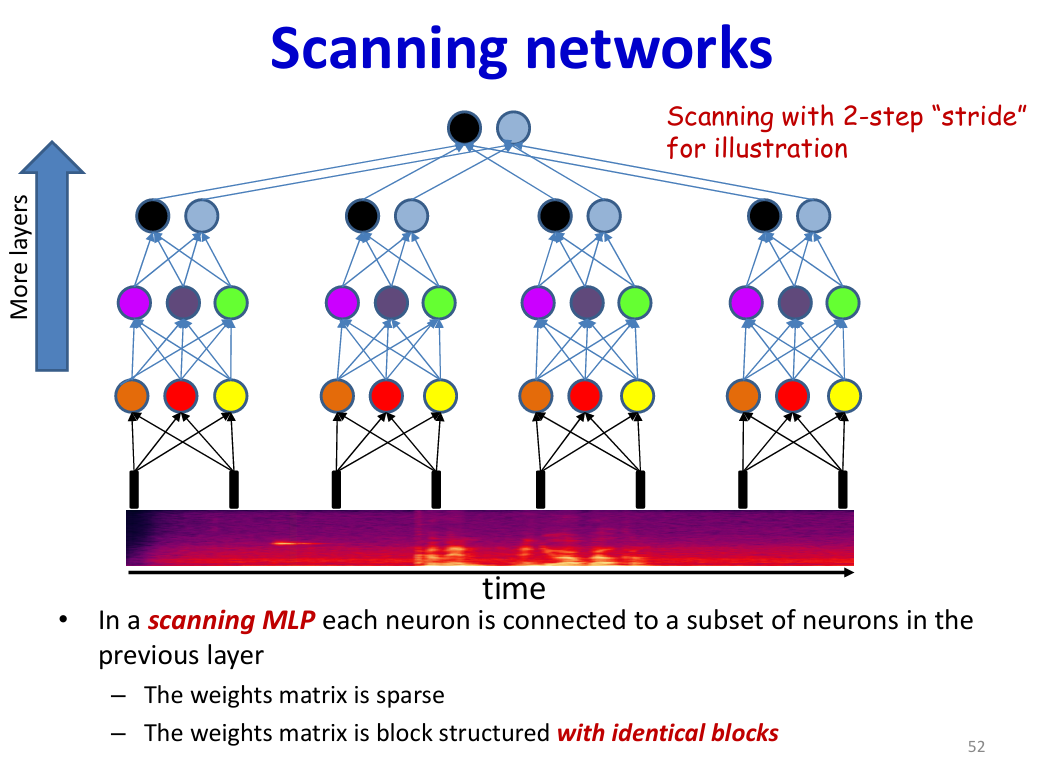

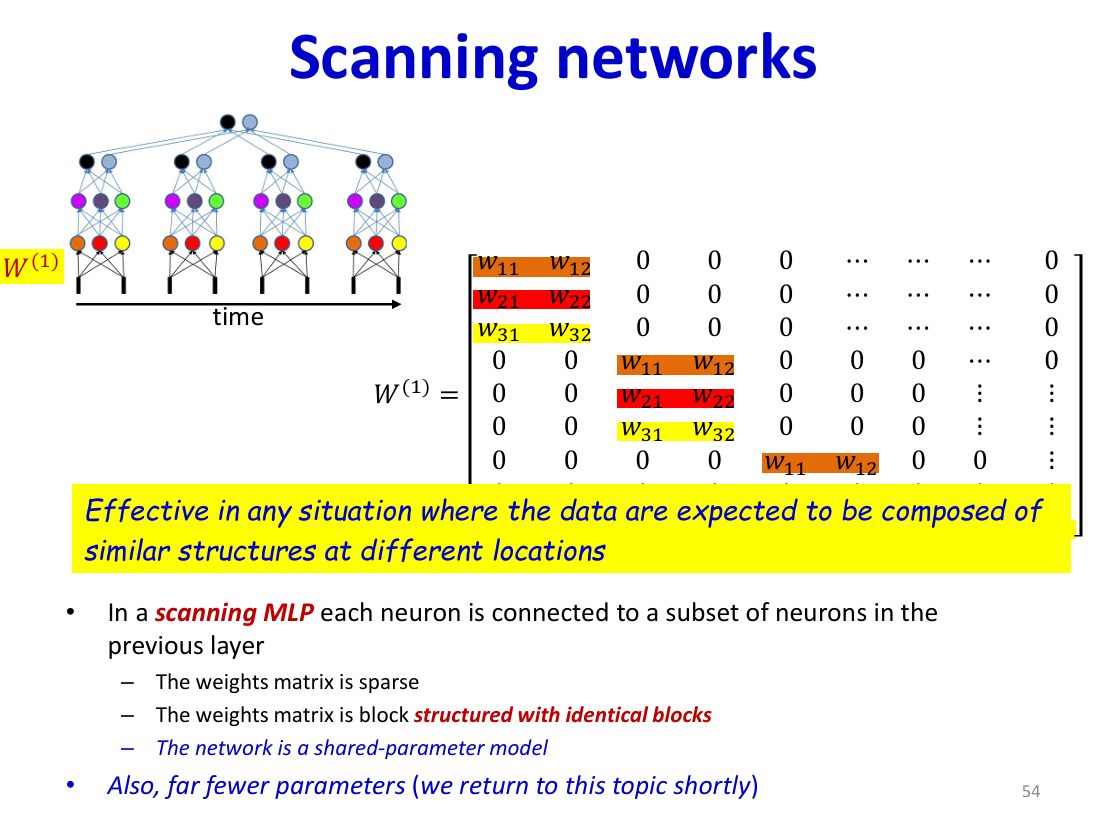

---

## Shared Parameter Model

> *"The network is a shared-parameter model"*

### What This Means:

If a weight $w_{11}$ changes in one location → **it must change everywhere** (every layer it contributes to)

### Training with Shared Parameters

During backpropagation, gradients from all locations are **summed**:

$$\frac{\partial \mathcal{L}}{\partial w_s} = \sum_{t=1}^{T-K+1} \frac{\partial \mathcal{L}}{\partial w_s^{(t)}}$$

where $w_s$ is the shared parameter.

This is what **enforces shift invariance**.

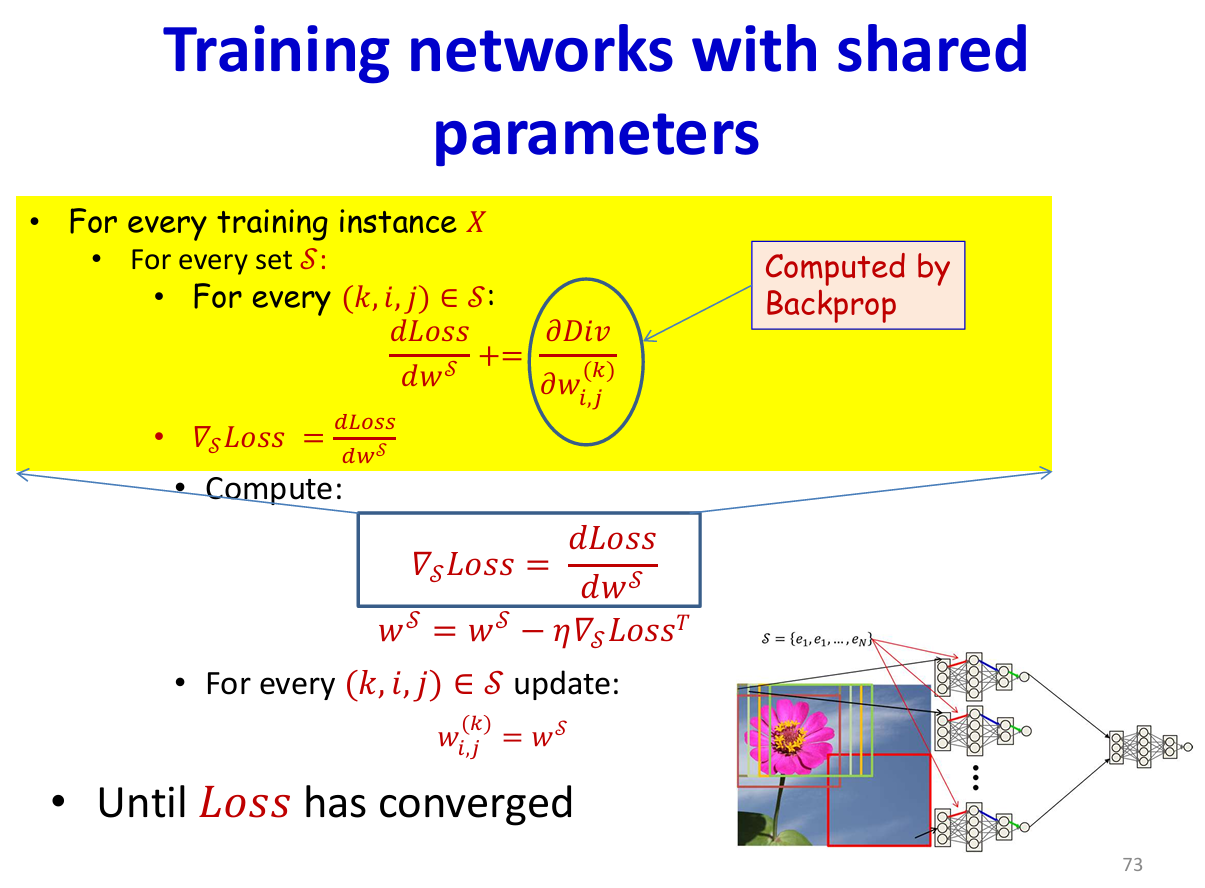

### What is Stride?

> **Stride** ($s$): How far the scanning window moves between evaluations.

$$\text{Output size} = \left\lfloor \frac{T - K}{s} \right\rfloor + 1$$

- Stride $s=1$: Maximum overlap, finest resolution
- Stride $s=K$: No overlap, fastest computation

# Scanning MLP Algorithm (1D)

This algorithm scans an input by sliding a window, applies the **same MLP** at each position using shared weights, computes activations layer-by-layer locally, and aggregates all location-wise outputs into a single decision.

## Algorithm Pseudocode

```
for l = 1:L                    # iterate over layers
    for t = 1:T-K+1            # scan over time/position
        for j = 1:D_l          # neurons in layer l

            if (l == 1)        # first layer operates on input
                y(0,:,t) = x(:, t:t+K-1)
            end

            z(l,j,t) = b(l,j)  # initialize with bias

            for i = 1:D_{l-1}  # sum over previous layer neurons
                z(l,j,t) += w(l,i,j) * y(l-1,i,t)
            end

            y(l,j,t) = activation(z(l,j,t))
        end
    end
end

Y = softmax(y(L,:,1) .. y(L,:,T-K+1))   # aggregate all positions
```

---

## Mathematical Formulation

### Forward Pass at Position $t$

**Layer 1 (Input Layer):**
$$\mathbf{y}^{(0)}_t = \mathbf{x}_{t:t+K-1}$$

**Hidden Layers ($l = 1, \ldots, L$):**

$$z^{(l)}_{j,t} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}$$

$$y^{(l)}_{j,t} = \sigma\left(z^{(l)}_{j,t}\right)$$

**Final Aggregation:**
$$\mathbf{Y} = \text{softmax}\left(\mathbf{y}^{(L)}_{:,1}, \mathbf{y}^{(L)}_{:,2}, \ldots, \mathbf{y}^{(L)}_{:,T-K+1}\right)$$

---

## Symbol Reference Table

| Symbol | Meaning |
|--------|---------|
| $\mathbf{x}$ | Input signal (e.g., spectrogram or time series) |
| $K$ | Window (patch) width |
| $T$ | Total input length |
| $l$ | Layer index |
| $j$ | Neuron index in current layer |
| $i$ | Neuron index in previous layer |
| $D_l$ | Number of neurons in layer $l$ |
| $y^{(l)}_{j,t}$ | Output of neuron $j$ in layer $l$ at position $t$ |
| $z^{(l)}_{j,t}$ | Pre-activation (weighted sum + bias) |
| $w^{(l)}_{i,j}$ | Weight from neuron $i$ (layer $l-1$) to neuron $j$ (layer $l$) |
| $b^{(l)}_j$ | Bias of neuron $j$ in layer $l$ |

---

## Output Dimensions

For input length $T$ and kernel size $K$ with stride $s=1$:

$$\text{Number of output positions} = T - K + 1$$

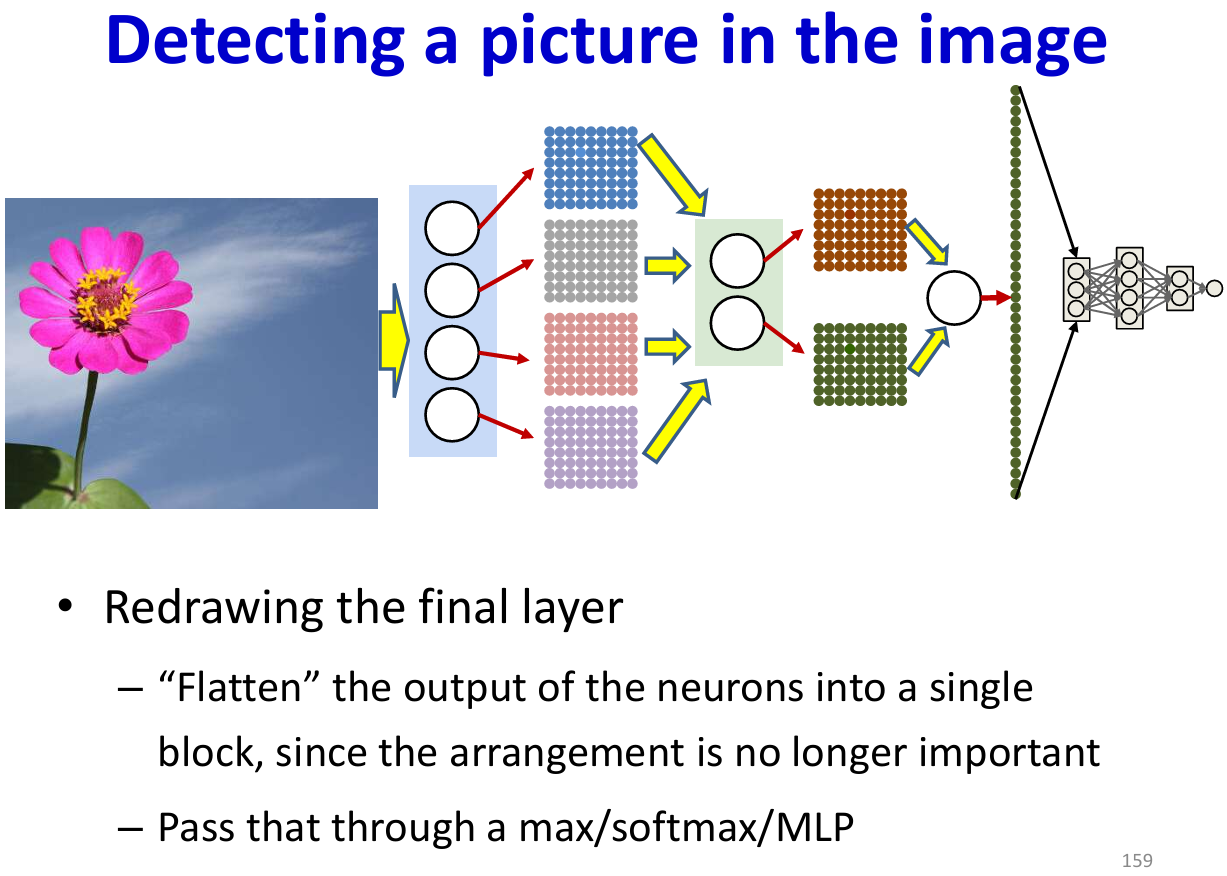

# Convolutional Neural Network (CNN) Algorithm

A CNN extends the scanning MLP to **2D spatial data** (images), scanning with kernels over both width and height dimensions.

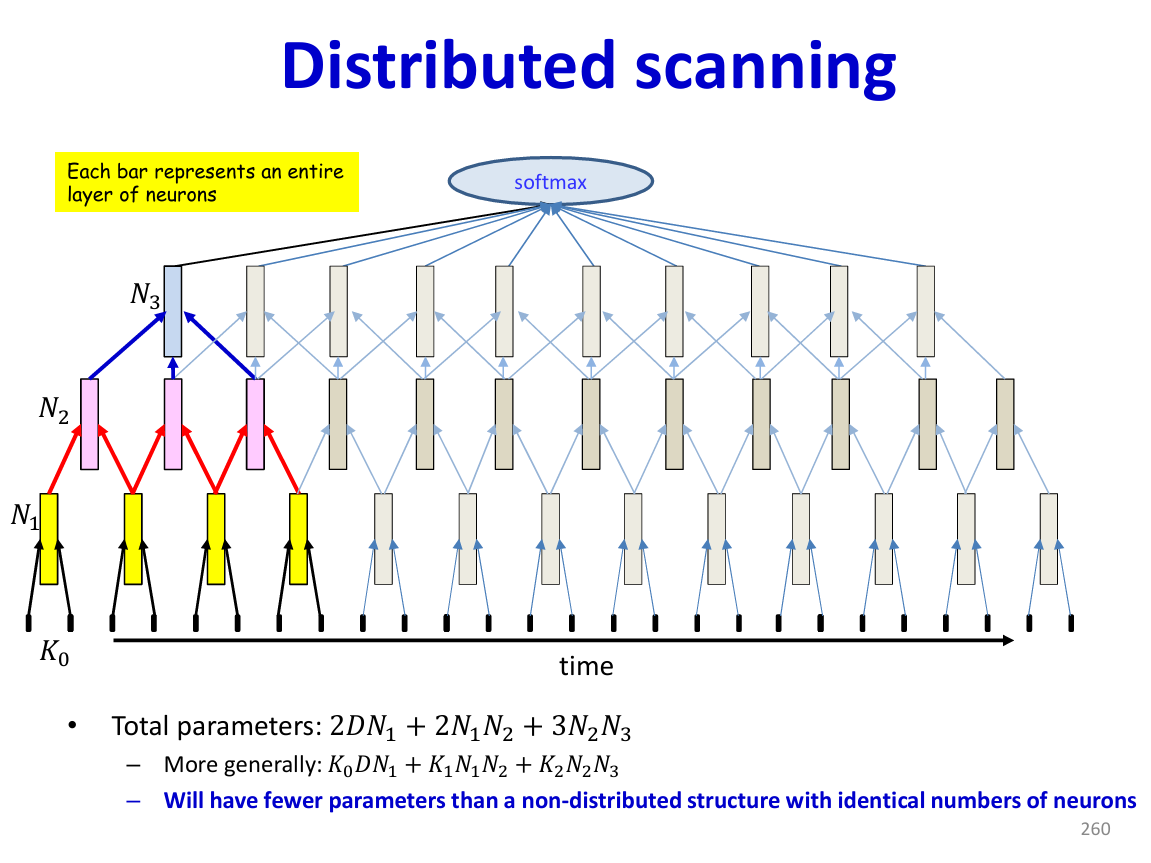

---

## Algorithm Pseudocode

```
Y(0,:,:,:) = Image                              # Initialize with input image

for l = 1:L                                     # iterate over layers
    for x = 1:W_{l-1} - K_l + 1                 # scan over width
        for y = 1:H_{l-1} - K_l + 1             # scan over height
            for j = 1:D_l                       # output filters in layer l

                z(l,j,x,y) = 0                  # initialize accumulator

                for i = 1:D_{l-1}               # input channels
                    for x' = 1:K_l              # kernel width
                        for y' = 1:K_l          # kernel height
                            z(l,j,x,y) += w(l,i,j,x',y') * Y(l-1,i,x+x'-1,y+y'-1)
                        end
                    end
                end

                Y(l,j,x,y) = activation(z(l,j,x,y))
            end
        end
    end
end

Y = softmax( Y(L,:,1,1) .. Y(L,:,W-K+1,H-K+1) )  # aggregate all spatial positions
```

---

## Mathematical Formulation

### Convolution Operation

For each layer $l$, output channel $j$, and spatial position $(x, y)$:

$$z^{(l)}_{j,x,y} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} \sum_{x'=1}^{K_l} \sum_{y'=1}^{K_l} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i, x+x'-1, y+y'-1}$$

$$Y^{(l)}_{j,x,y} = \sigma\left(z^{(l)}_{j,x,y}\right)$$

### In Compact Notation (Convolution Operator):

$$\mathbf{Y}^{(l)}_j = \sigma\left( \sum_{i=1}^{D_{l-1}} \mathbf{W}^{(l)}_{i,j} * \mathbf{Y}^{(l-1)}_i + b^{(l)}_j \right)$$

where $*$ denotes the 2D convolution operation.

---

## Symbol Reference Table

| Symbol | Meaning |
|--------|---------|
| $\text{Image}$ | Input image (2D signal with channels) |
| $Y^{(l)}_{i,x,y}$ | Output of channel $i$ in layer $l$ at spatial location $(x,y)$ |
| $l$ | Layer index |
| $j$ | Output filter (channel) index |
| $i$ | Input channel index |
| $D_l$ | Number of filters (output channels) in layer $l$ |
| $K_l$ | Kernel (filter) size at layer $l$ |
| $W_l, H_l$ | Width and height of feature maps at layer $l$ |
| $w^{(l)}_{i,j,x',y'}$ | Weight connecting input channel $i$ to output channel $j$ at kernel offset $(x', y')$ |
| $b^{(l)}_j$ | Bias for filter $j$ in layer $l$ |

---

## Output Feature Map Dimensions

For input size $W \times H$, kernel size $K$, padding $P$, and stride $S$:

$$W_{out} = \left\lfloor \frac{W - K + 2P}{S} \right\rfloor + 1$$

$$H_{out} = \left\lfloor \frac{H - K + 2P}{S} \right\rfloor + 1$$

---

## Key Insight

> **A CNN is nothing more than a scanning MLP whose scanning operation has been algebraically reorganized into convolution for efficiency and structure.**

| Scanning MLP | CNN |
|--------------|-----|
| Explicit loop over positions | Convolution operator |
| Same weights at each position | Shared filter weights |
| Sequential computation | Parallelizable matrix operations |

Both achieve **shift invariance** through **weight sharing** across spatial locations.

# Summary: From MLP to CNN

## The Progression

| Concept | Description |
|---------|-------------|
| **Standard MLP** | Dense connections, no spatial awareness, position-dependent |
| **Scanning MLP** | Shared weights, slides over input, achieves shift invariance |
| **CNN** | Scanning MLP reorganized as convolution, efficient 2D extension |

## Key Equations at a Glance

### 1. Standard MLP Layer
$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

### 2. Scanning MLP (1D)
$$y^{(l)}_{j,t} = \sigma\left(b^{(l)}_j + \sum_{i} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}\right)$$

### 3. CNN Convolution (2D)
$$Y^{(l)}_{j,x,y} = \sigma\left(b^{(l)}_j + \sum_{i} \sum_{x'} \sum_{y'} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i,x+x'-1,y+y'-1}\right)$$

---

## Why Shift Invariance Matters

$$\text{If } f(\mathbf{x}) = \text{"pattern detected"} \implies f(\text{shift}(\mathbf{x})) = \text{"pattern detected"}$$

This is achieved through:
1. **Weight sharing** — same $\mathbf{W}$ at every position
2. **Local receptive fields** — each neuron sees only a patch
3. **Aggregation** — max/softmax over all positions